In [2]:
# install dependencies
# !pip install casadi

# Safe Autonomy Tutorial: Motion Planning

In this tutorial, you will get familiar with different optimization-based motion planning techniques to obtain a collision-free trajectory for a dynamical system. We will reuse parts from the 0th tutorial, so you should be familiar the optimization problem formulation. The overall assignment is seperated into three parts:

1.   E-Level: Optimization-based motion planning Intro
2.   C-Level: Optimization-based motion planning in dynamic environments + Feedback motion primitive generation
3.   A-Level: A*-based motion planning with feedback motion primitives



In [1]:
import numpy as np
from math import *

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy

## Optimization-based Motion Planning: Static Obstacles

The goal of this section is to find a dynamically feasible trajectory from an initial state to a goal state while optimizing a performance measure subject to obstacle avoidance constraints. The standard formulation of an optimization (or optimal control) problem can be formulated as

$$
\begin{aligned}
	\min_{\mathbf{u}_{1:N-1}, \mathbf{x}_{1:N}} \quad &\sum_{t=1}^{N} J(\mathbf{x}_t, \mathbf{u}_t)\\
	\textrm{s.t.  } \quad  &\mathbf{x}_{t+1} = \mathbf{f}\left(\mathbf{x}_t, \mathbf{u}_t\right) \hspace{0.5cm} &&\forall t = 1, \cdots, N-1\\
  &\mathbf{x}_{t}  \notin \mathcal{X}_{obs} \hspace{0.5cm} &&\forall t = 1, \cdots, N\\
  & \mathbf{u}_t \in \mathcal{U} &&\forall t = 1, \cdots, N-1\\
	& \mathbf{x}_N \in \mathcal{X}_g, \mathbf{x}_0 = \mathbf{x}(t_0)
    \end{aligned}.
$$
where $J$ is the stage cost and $\mathcal{X}_{obs}$ is the set of obstacle positions.

First, we define the environment in which our robot (drone from 0th tutorial) is operating. This 2d environment consists of a number of polygon obstacle regions. A single convex polygon is given as a list of points.

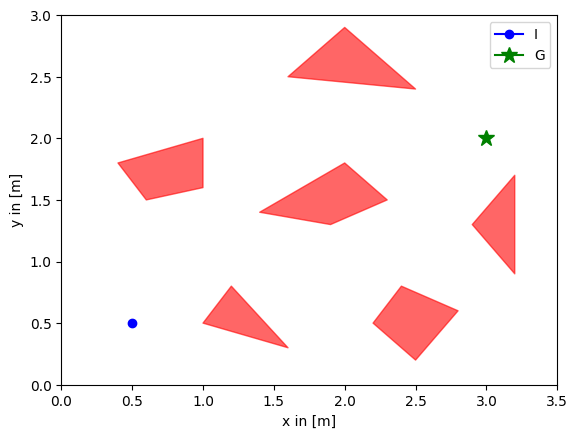

In [2]:
# Initial state of the robot
x0 = [0.5, 0.5, 0.]

# Goal state
xG = [3., 2., 0.]

# For collision checking we will overapproximate the robot with a circle of radius r
r = 0.15

# Define obstacles in the environment (Each obstacle is defined by a list of its vertex positions)
obstacles = []
obstacles.append([[1., 0.5], [1.2, 0.8], [1.6, 0.3]])
obstacles.append([[0.6, 1.5], [0.4, 1.8], [1., 2.], [1., 1.6]])
obstacles.append([[1.4, 1.4], [2., 1.8], [2.3, 1.5], [1.9, 1.3]])
obstacles.append([[2.9, 1.3], [3.2, 1.7], [3.2, 0.9]])
obstacles.append([[2.5, 0.2], [2.2, 0.5], [2.4, 0.8], [2.8, 0.6]])
obstacles.append([[1.6, 2.5], [2., 2.9], [2.5, 2.4]])


# Plot environment
fig, ax = plt.subplots()

patches = [] # List of Polygon type obstacles
for obs in obstacles:
    p = Polygon(obs)
    patches.append(p)
    

p_col = PatchCollection(patches, alpha=0.6)
p_col.set_color([1, 0, 0])
ax.add_collection(deepcopy(p_col))
ax.plot([x0[0]], [x0[1]], marker='o', color="b", label="I") # Initial state
ax.plot([xG[0]], [xG[1]], marker='*', color="g", markersize=12, label = "G") #Goal state in Blue
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.legend()
plt.show()


Typically, we distinguish between different optimization techniques such as gradient-based or sampling-based optimization. There are lots of different reasons why one approach is more suitable than the other one which depends heavily on the problem setting. In the following, we will focus on gradient-based approaches in which it is crucial to have smooth cost functions and constraints. If cost or constraint functions are nonsmooth, gradient-based approaches may fail as the gradient does not exist at discontinuities. In case you want to learn more about numerical optimization in general, I can recommend $\href{https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf}{this}$ (Convex Optimization) and $ \href{https://algorithmsbook.com/optimization/files/optimization.pdf}{this}$ (Algorithms for Optimization) book.


Ideally, to set up the optimization problem, we would like to say something like "distance between robot and polygons greater than XX". However, the distance function between a polygon and a point has a nonsmooth gradient which will complicate standart optimization techniques. Therefore, we will introduce a commonly used smooth approximation: Minimum Volume Enclosing Ellipsoids (MVEE). An ellipsoid can be described by

\begin{align}
\mathcal{E} = \left\{ \mathbf{x} \in \mathbb{R}^n \mid \left(\mathbf{x} - \mathbf{c}\right)^T \mathbf{A} \left(\mathbf{x} - \mathbf{c}\right) \leq 1\right\}
\end{align}
where $\mathbf{A} \in \mathbb{R}^{n \times n}$ and $\mathbf{c} \in \mathbb{R}^n$ is the center of the ellipsoid. There are a lot of different approaches to obtain the minimmum ellipse that contains a given polygon $\mathcal{P}$. One of these approaches is implemented in the following, if you would like to read up on that, I would recommend Chapter 8.4.1 of "Convex Optimization".



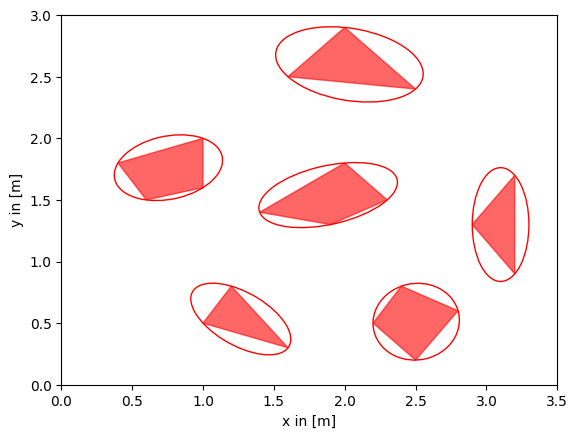

In [3]:
from matplotlib.patches import Ellipse

# MVEE algorithm
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, np.linalg.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = np.linalg.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = np.linalg.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c

# initialize list of ellipsoids [(A_1, c_1), ...]
obstacle_ellipsoids = []

for obs in obstacles:
    A, c = mvee(np.array(obs))
    obstacle_ellipsoids.append((A, c))


# Visualize environment
fig, ax = plt.subplots()

ax.add_collection(deepcopy(p_col))

ellipses = []
for (A, c) in obstacle_ellipsoids:
    # Eigendecomposition of A
    # print(A,c, "\n")
    Lambda, R = np.linalg.eig(A)
    width = 2 * sqrt(1 / Lambda[0]) 
    height = 2 * sqrt(1 / Lambda[1])
    angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
    ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
    ellipse.set_edgecolor([1, 0, 0])
    ellipses.append(ellipse)
    ax.add_artist(copy(ellipse))
    
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
plt.show()


We will now focus on formulating our constraint $\mathbf{x}_t \notin \mathcal{X}_{obs} \forall t=0,\dots,N$. Since MVEE's are strictly overapproximating the polygons $\mathcal{P}$ it is true that $\mathbf{x}_t \notin \bigcup_{i=1}^M \mathcal{E} \implies \mathbf{x}_t \notin \mathcal{X}_{obs}$, where $M=6$ is the number of obstacles. However, in this formulation, we treat the robot as a point in 2D space which is not capturing the robot's volume. In this assignment, we approximate the robots collision box by a circle of radius $r$ and position $\mathbf{x}$. 

Hence, in order to formulate proper obstacle avoidance constraints, we would like to obtain the enlarged ellipsoids $\tilde{\mathcal{E}}_i$ such that
\begin{align}
\mathbf{x}_t \notin \tilde{\mathcal{E}}_i \implies \mathrm{dist}\left(\mathbf{x}_t, \mathcal{E}\right) \geq r
\end{align}
holds. The key ingredient to obtain the enlarged ellipses is to obtain the minkowski sum $\tilde{\mathcal{E}}_i = \mathcal{E} \bigoplus \mathcal{B}_2(r)$ where $\mathcal{B}_2(r)$ is a circle of radius $r$. In the following, create a list of tuples $enlarged_ellipses = [(\tilde{\mathbf{A}}_1, \tilde{\mathbf{c}}_1), \dots, (\tilde{\mathbf{A}}_M, \tilde{\mathbf{c}}_M)]$ that contains the enlarged ellipses. Hint: Use an Eigendecomposition to obtain the ellipse equation in normal form $\left(\frac{x}{a}\right)^2 + \left(\frac{y}{b}\right)^2 = 1$ where $a, b$ are half the length of the major and minor axes.

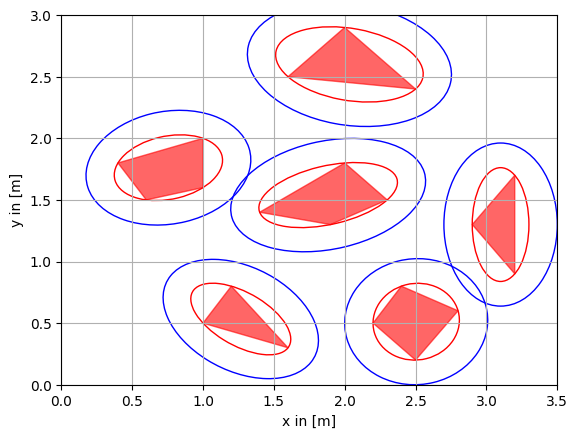

In [4]:
# radius robot
r = 0.2

# init empty lists
enlarged_ellipses = []

# The eigendecomposition of an eclipse results in major and minor axis lengths of 1/sqrt(lambda2), 1/sqrt(lambda2)
# Add r to major and minor axis s.t lengths become 1/sqrt(lambda2) +r, 1/sqrt(lambda1) +r

  
# generate plot objects
enlarged_ellipses_patches = []
for (A, c) in obstacle_ellipsoids:
  Lambda, R = np.linalg.eig(A) # Returns eigenvectors and eigenvalues
  axis_w = (sqrt(1 / Lambda[0])+r)
  axis_h = (sqrt(1 / Lambda[1]) +r)
  lambda_w = 1/ axis_w**2
  lambda_h = 1/ axis_h**2
  A_tilde = R @ np.array([[lambda_w, 0], [0, lambda_h]]) @ (R).T
  c_tilde = c
  enlarged_ellipses.append((A_tilde, c_tilde))
  # Multiple by 2 to get the whole width and height length of the eclipse
  width = 2 * axis_w 
  height = 2 * axis_h
  angle = atan2(R[1, 0], R[0, 0]) * 180 / pi
  ellipse = Ellipse(c, width, height, angle=angle, facecolor='none')
  ellipse.set_edgecolor([0, 0, 1])
  enlarged_ellipses_patches.append(ellipse)


    
fig, ax = plt.subplots()

for e_ in enlarged_ellipses_patches:
    ax.add_artist(copy(e_))

for e in ellipses:
    ax.add_artist(copy(e))

ax.add_collection(deepcopy(p_col))
ax.set_xlim([0,3.5])
ax.set_ylim([0,3])
ax.set_xlabel("x in [m]")
ax.set_ylabel("y in [m]")
ax.grid("True")
plt.show()

# print(enlarged_ellipses)



Now that we have obtained a smooth expression for collision checking with the obstacles based on just the robot position $\mathbf{x}_t$, we can formulate our motion planning problem in `casadi`. Implement the optimization problem for a quadratic cost function of the form
\begin{align}
J\left(\mathbf{x}_t, \mathbf{u}_t\right) = \left(\mathbf{x}_t - \mathbf{x}_G\right)^T \mathbf{Q} \left(\mathbf{x}_t - \mathbf{x}_G\right) + \mathbf{u}^T \mathbf{R} \mathbf{u}_t  
\end{align}
for $\mathbf{Q} = \mathbf{I}_{3 \times 3}$ and $\mathbf{R} = \mathrm{diag}([2, 2])$. The dynamics model is given by
$$
\begin{bmatrix}
    x_{k+1}\\
    y_{k+1}\\
    \theta_{k+1}
    \end{bmatrix} = \begin{bmatrix}
    x_k - u_1 \Delta t sin(\theta)\\
    y_k + u_1 \Delta t cos(\theta)\\
     \theta _k + u_2 \Delta t
\end{bmatrix}.
$$
and the feasible control set is defined as $\mathcal{U} = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0 \leq u_1 \leq 1\right\}$. Hint: Remember to use `casadi` functions for the trigonometric functions.

In [ ]:
# Working function
# Change to x0_casadi using parameter and set_value
# Change R and Q using ca.eye
import casadi as ca
import casadi.tools as ctools
import numpy as np

opti = ca.Opti()

# Define dimensions
Nx = 3
Nu = 2
Nt = 100
dt = 0.1

# Setup for initial guesses
xG = [3., 2., 0.]
x0 = [0.5, 0.5, 0.]

# Decision variables for state trajectory
x = opti.variable(Nx, Nt+1)
u = opti.variable(Nu, Nt)

# Initial state of the robot
x0_casadi = opti.parameter(Nx, 1)
opti.set_value(x0_casadi, x0)


# Goal state of the robot
xG_casadi = opti.parameter(Nx, 1)
opti.set_value(xG_casadi, xG)


# Define Q & R variables
Q = ca.DM.eye(Nx)
R = 2* ca.DM.eye(Nu)


# Dynamic constraint using model
for k in range(Nt):
    x1 = x[0, k] - u[0, k] * dt * ca.sin(x[2, k])
    x2 = x[1, k] + u[0, k] * dt * ca.cos(x[2, k])
    x3 = x[2, k] + (u[1, k]* dt)
    x_k_next = ca.vertcat(x1, x2, x3)
    opti.subject_to(x[:, k+1] == x_k_next)

# Dynamic constraint knowing static obstacles
for k in range(Nt+1):
    for (A_tilde, c_tilde) in enlarged_ellipses:
        A_tilde = ca.MX(A_tilde) 
        c_tilde = ca.MX(c_tilde)
        xy_only = x[0:2, k]
        constraint = (xy_only-c_tilde).T @ A_tilde @ (xy_only-c_tilde)
        opti.subject_to(constraint > 1)


# Initial & terminal dynamic constraints
opti.subject_to(x[:, 0] ==x0_casadi)
opti.subject_to( x[:, -1] == xG_casadi)

# Input constraints, for all of u time steps
opti.subject_to(opti.bounded(0, u[0, :], 1))

# Update cost function
J = 0 
for k in range(Nt):
    x_diff = (x[:, k] -xG_casadi)
    J += x_diff.T @ Q @ x_diff + u[:, k].T @ R @ u[:,k]

# Optimization problem
opti.minimize(J)

# Set initial guesses
x_initial = np.linspace(x0[0], xG[0], Nt+1)
gradient = (xG[1] - x0[1]) / (xG[0] - x0[1])
intercept = xG[1] - gradient*xG[0]
y_initial = gradient*x_initial + intercept

opti.set_initial(x[0, :], x_initial.T)
opti.set_initial(x[1, :], y_initial.T)


# Create solver
opti.solver('ipopt')

# Extract the solution
sol = opti.solve()

x_optimal = sol.value(x)
u_optimal = sol.value(u)

print("Optimal x:", x_optimal)
print("Optimal u:", u_optimal)

traj = x_optimal
# print(traj)


After solving the optimization problem, we can visualize our results!

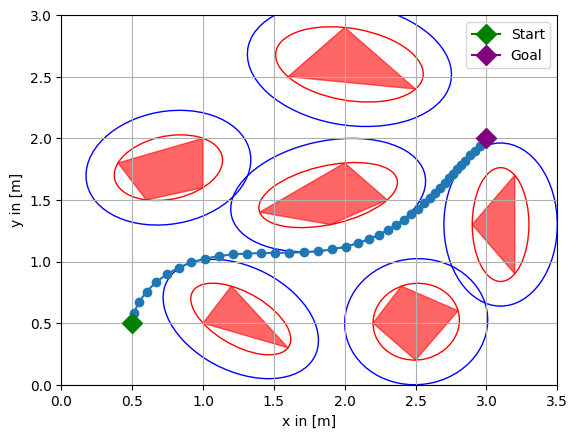

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(traj[0, :], traj[1, :], marker='o')
ax1.plot(x0[0], x0[1], color= 'g',marker = 'D', markersize = 10, label = "Start")
ax1.plot(xG[0], xG[1], color= 'purple',marker = 'D', markersize = 10, label = "Goal")

for e_ in enlarged_ellipses_patches:
    ax1.add_artist(copy(e_))

for e in ellipses:
    ax1.add_artist(copy(e))
      

ax1.add_collection(copy(p_col))
ax1.set_xlim([0,3.5])
ax1.set_ylim([0,3])
ax1.set_xlabel("x in [m]")
ax1.set_ylabel("y in [m]")
ax1.legend()
plt.grid()
plt.show()


**Aaand also animate!**

In [8]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *
N = Nt
def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    ax.add_collection(deepcopy(p_col))
    
    return line1, pt

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),  
                          frames=N, interval=50, blit=True)
# plt.show()
# HTML(animation.to_html5_video())
animation.save('Videos/Tut2/1_MovRob.gif', writer='pillow')


<IPython.core.display.Javascript object>

![Animation](Videos/Tut2/1_MovRob.gif)


## Optimization-based Motion Planning: Dynamic Obstacles
Now we will start with moving obstacles! In this case we will assume that the obstacles start in the previous configuration and have a constant velocity in one direction. In the following, create a list of the obstacles at each timestep $t = 0, \dots, N$.

In [9]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

# velocity vectors in xy-plane
velocity_dirs = np.array([[1., 0.], [1., 0.4], [0.4, -1.], [-1, 0.5], [-0.1, 1.], [1., 0.2]])

# velocity magnitudes
velocities = np.array([0.1, 0.15, 0.1, 0.4, 0.3, 0.05])

velocity_dirs_norm = velocities[:, np.newaxis] * velocity_dirs / np.linalg.norm(velocity_dirs, axis=1)[:, np.newaxis]


velocity_dirs_norm = velocity_dirs_norm.tolist()
velocities = velocities.tolist()
# list of obstacles at each timestep
timed_obstacles = []
timed_obstacles.append(deepcopy(obstacles))

speed_obstacles = []
speed_obstacles.append(deepcopy(obstacles))


for k in range(1, Nt):
    all_obstacles = []
    for obs_indx, timed_obs in enumerate(speed_obstacles[0]):
        new_obstacle_set = []
        for point in timed_obs:
            timed_x = point[0] + dt* velocity_dirs_norm[obs_indx][0]
            timed_y = point[1] + dt* velocity_dirs_norm[obs_indx][1]
            new_point = [timed_x, timed_y]
            new_obstacle_set.append(new_point)

        all_obstacles.append(new_obstacle_set)

        speed_obstacles[0][obs_indx] = new_obstacle_set # overwrite so that it will update the same obstacle_set again

    timed_obstacles.append(all_obstacles) #make sure to append 
# print(timed_obstacles)



In [10]:
def animation_obstacles(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)
    
    return moving_patches,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

animation = FuncAnimation(fig, animation_obstacles, frames=N, interval=50, blit=True)

# HTML(animation.to_html5_video())
animation.save('Videos/Tut2/2_MovObs.gif', writer='pillow')



<IPython.core.display.Javascript object>

![Animation](Videos/Tut2/2_MovObs.gif)

To use the same constraint formulations as before, we need the ellipsoidal overapproximations over time!

In [11]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook


# list of list of ellipses at each time step
timed_ellipses = []

for timed_obs in timed_obstacles:
    new_ellipse = []
    for obs in timed_obs:
       A, c = mvee(np.array(obs))
       Lambda, R = np.linalg.eig(A) # Returns eigenvectors and eigenvalues
       axis_w = (sqrt(1 / Lambda[0])+r)
       axis_h = (sqrt(1 / Lambda[1]) +r)
       lambda_w = 1/ axis_w**2
       lambda_h = 1/ axis_h**2
       A_new = R @ np.array([[lambda_w, 0], [0, lambda_h]]) @ (R).T
       c_new = c
       new_ellipse.append((A_new, c_new))
    timed_ellipses.append(new_ellipse)

# print(timed_ellipses[0])
    


In [14]:
# Animations
def animation_ellipses(i):
    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)
    
    for j, e in enumerate(moving_ellipses):
        e.set_center(timed_ellipses[i][j][1])
    
    return moving_patches, moving_ellipses,


fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])


moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

moving_ellipses = []
for e in enlarged_ellipses_patches:
  moving_ellipses.append(Ellipse(e.get_center(), e.width, e.height, angle=e.angle, facecolor='none'))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)
    
for e in moving_ellipses:
    e.set_edgecolor([0, 0, 1])
    ax.add_artist(e)

animation = FuncAnimation(fig, animation_ellipses, frames=N, interval=50, blit=True)

# plt.show()
# HTML(animation.to_html5_video())
animation.save('Videos/Tut2/3_EnlMovObs.gif', writer='pillow')


<IPython.core.display.Javascript object>

![Animation](Videos/Tut2/3_EnlMovObs.gif)


**We're almost there!** Formulate the optimization problem in the case of moving obstacles!

In [ ]:
# Working function
# Change to x0_casadi using parameter and set_value
# Change R and Q using ca.eye
import casadi as ca
import casadi.tools as ctools
import numpy as np

opti = ca.Opti()

# Define dimensions
Nx = 3
Nu = 2
Nt = 100
dt = 0.1

# Setup for initial guesses
xG = [3., 2., 0.]
x0 = [0.5, 0.5, 0.]

# Decision variables for state trajectory
x = opti.variable(Nx, Nt+1)
u = opti.variable(Nu, Nt)

# Initial state of the robot
x0_casadi = opti.parameter(Nx, 1)
opti.set_value(x0_casadi, x0)


# Goal state of the robot
xG_casadi = opti.parameter(Nx, 1)
opti.set_value(xG_casadi, xG)


# Define Q & R variables
Q = ca.DM.eye(Nx)
R = 2* ca.DM.eye(Nu)


# Dynamic constraint using model
for k in range(Nt):
    x1 = x[0, k] - u[0, k] * dt * ca.sin(x[2, k])
    x2 = x[1, k] + u[0, k] * dt * ca.cos(x[2, k])
    x3 = x[2, k] + (u[1, k]* dt)
    x_k_next = ca.vertcat(x1, x2, x3)
    opti.subject_to(x[:, k+1] == x_k_next)

# Dynamic constraint knowing dynamic obstacles

# DIFFERENT: NT ONLY and go through every moving obstacle timed_ellipses[k]
for k in range(Nt):
    for (A_tilde, c_tilde) in timed_ellipses[k]:
        A_tilde = ca.MX(A_tilde) 
        c_tilde = ca.MX(c_tilde)
        xy_only = x[0:2, k]
        constraint = (xy_only-c_tilde).T @ A_tilde @ (xy_only-c_tilde)
        opti.subject_to(constraint > 1)


# Initial & terminal dynamic constraints
opti.subject_to(x[:, 0] ==x0_casadi)
opti.subject_to( x[:, -1] == xG_casadi)

# Input constraints, for all of u time steps
opti.subject_to(opti.bounded(0, u[0, :], 1))

# Update cost function
J = 0 
for k in range(Nt):
    x_diff = (x[:, k] -xG_casadi)
    J += x_diff.T @ Q @ x_diff + u[:, k].T @ R @ u[:,k]

# Optimization problem
opti.minimize(J)

# Set initial guesses
x_initial = np.linspace(x0[0], xG[0], Nt+1)
gradient = (xG[1] - x0[1]) / (xG[0] - x0[1])
intercept = xG[1] - gradient*xG[0]
y_initial = gradient*x_initial + intercept

opti.set_initial(x[0, :], x_initial.T)
opti.set_initial(x[1, :], y_initial.T)


# Create solver
opti.solver('ipopt')

# Extract the solution
sol = opti.solve()

x_optimal = sol.value(x)
u_optimal = sol.value(u)

print("Optimal x:", x_optimal)
print("Optimal u:", u_optimal)

traj = x_optimal
# print(traj)

Visualization of the obtained trajectory.

In [19]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from math import *

def animation_func(i, data):
    x = data[0]
    y = data[1]
    theta = data[2]
    # Drone dimension: width l
    l = 0.3
    p1 = [x[i] + cos(theta[i]) * l/2, y[i] + sin(theta[i]) * l/2]
    p2 = [x[i] - cos(theta[i]) * l/2, y[i] - sin(theta[i]) * l/2]
    line1.set_xdata([p1[0], p2[0]])
    line1.set_ydata([p1[1], p2[1]])
    # Plot trajectory
    pt, = ax.plot([x[i]], [y[i]], "g.", markersize=1)

    for j, p in enumerate(moving_patches):
        new_pos = np.append(timed_obstacles[i][j], [timed_obstacles[i][j][0]], axis=0)
        p.set_xy(new_pos)
    
    return line1, pt, moving_patches,

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.set_xlim([0., 4.])
ax.set_ylim([0., 4.])
line1, = ax.plot([x0[0]-0.15, x0[0] + 0.15], [0., 0.], 'ko-', lw=1.5, markersize=5)

moving_patches = []
for p in patches:
  moving_patches.append(Polygon(p.get_xy()))

for p in moving_patches:
    p.set_color([1, 0, 0])
    ax.add_patch(p)

x_data = traj[0, :]
y_data = traj[1, :]
theta_data = traj[2, :]
animation = FuncAnimation(fig, animation_func, fargs=((x_data, y_data, theta_data),),  
                          frames=N, interval=50, blit=True)
# plt.show()
# HTML(animation.to_html5_video())
animation.save('Videos/Tut2/4_Mov_ObsRob.gif', writer='pillow')

<IPython.core.display.Javascript object>

![Animation](Videos/Tut2/4_Mov_ObsRob.gif)

# What if we have uncertainties such as initial positions? Feedback Motion Primitives!

In the previous setting, we have found an open loop trajectory for our robot. When applying this to a real robot it will most likely fail if we do not use a tracking controller to account for small deviations from the reference trajectory.

However, if we deviate from the reference trajectory, we are not ensured anymore that the robot will move on a collision-free trajectory. So in safety-critical applications, it is important to consider safety on different levels of the planning hierarchy (motion planning, control) in order to make our robots more robust. 

In this section, we will look into Feedback motion primitives to ensure safety even if the reference trajectory cannot be tracked accurately.

In [21]:
# !pip install pypolycontain
import pypolycontain as pp 

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, MultiPoint
from shapely.geometry import Polygon as Poly

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from copy import deepcopy, copy
from math import *

import numpy as np

# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

We first use our well-known dynamics model to be able to simulate our system.

In [22]:
def dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: derivative of the state vector
    """
    dx = np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T
    return dx


def discrete_dynamics(x, u):
    """
    Inputs: current state of the system x, control input u
    Output: next state vector
    """
    dt = 0.1
    x_next = x + dt * dynamics(x, u)
    return x_next

Next, we will define our set of initial states as well as our input set. From this we will construct a **single** feedback motion primitive. Later, we will generalize these results to obtain multiple primitives that can be used for planning. In the following, define two zonotopes $X0$ and $U$ for the previously mentioned sets. The initial set is centered at the origin with orientation zero and has a total width of $0.1$ in each state direction. The input set is defined as $U = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, 0.5 \leq u_2 \leq 1\right\}$.

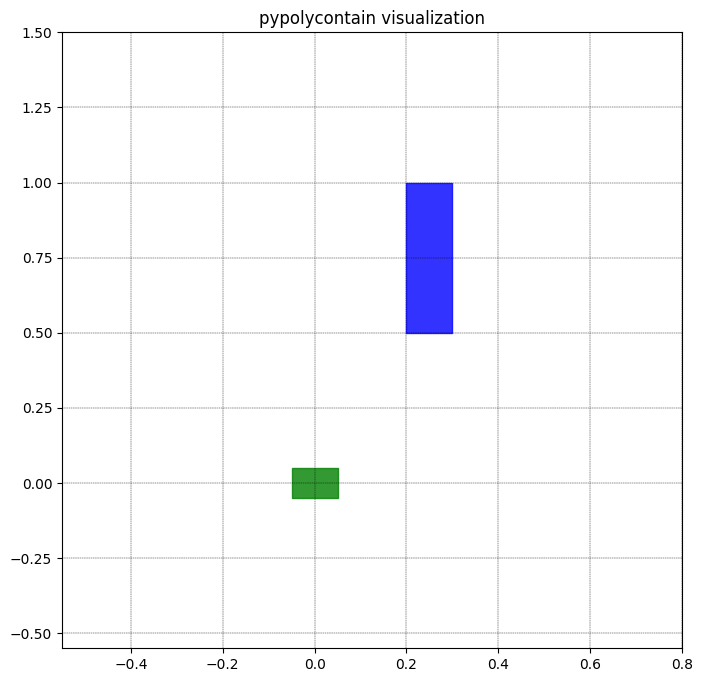

In [23]:
%matplotlib inline
nx = 3
nu = 2
X0 = pp.zonotope(x= np.array([0,0,0]), G = np.array([[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]]))
U = pp.zonotope(x = np.array([0.25, 0.75]), G= np.array([[0.05, 0], [0, 0.25]])) #correct one
U.color = 'blue'
# visualize initial set
fig, ax = plt.subplots()
try:
    pp.visualize([U, pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :])], ax=ax, fig=fig)
except:
    pass


Next, we would like to be able to sample trajectories from our system given the initial states and the input sets. For that purpose, we need a function that allows us to sample a point from a zonotope. 

In [24]:
import random
def sample_zonotope(zt):
  """
  Input: pp zonotope
  Output: uniformly sampled point inside zonotope
  """
  z_center = zt.x
  x = [center -zt.G[ind][ind] + random.random() * 2* zt.G[ind][ind] for ind, center in enumerate(z_center)]

  return x

print(sample_zonotope(X0))

[0.002276492497780315, -0.04408132982221106, 0.025262785365895046]


We will now sample a bunch of initial states and input trajectories of length $N_s = 20$ to fit a linear model to the multi-step solution of our dynamical system. Fill the matrices!

In [25]:
# number of timesteps for feedback motion primitive
N_s = 20

# sampled trajectories
n_samples = 10000

# ORDER AS SAMPLES, STATE, TIME --> Setup required for Linear Regression 
state_traces = np.zeros((n_samples, nx, N_s)) # 10000, 3, 20
input_traces = np.zeros((n_samples, nu, N_s - 1)) # 10000, 2, 19

# Check extremes
state_extreme_1 = np.zeros((1, nx, N_s)) # 10000, 3, 20
state_extreme_2 = np.zeros((1, nx, N_s)) 
input_extreme_1 = np.zeros((1, nu, N_s - 1))
input_extreme_2 = np.zeros((1, nu, N_s - 1))



# Define input traces
for n in range(N_s-1):
    for j in range(n_samples):
        input_traces[j, :, n] = sample_zonotope(U)
        
    # Extreme U only
    input_extreme_1[:, :, n] = [0.2, 1.0]
    input_extreme_2[:, :, n] = [0.3, 0.5] 

# Define first column of state_traces, needed in order to compute the future time values
for j in range(n_samples):
    state_traces[j, :, 0] = sample_zonotope(X0)
#Find Extremes
state_extreme_1[:, :, 0] = sample_zonotope(X0)
state_extreme_2[:, :, 0] = sample_zonotope(X0)

# Fill in rest of the columns using discrete_dynamics
for i in range(N_s-1):
    x_next = discrete_dynamics(state_traces[:, :, i], input_traces[:, :, i])
    state_traces[:, :, i+1] = x_next

    # Extreme States only
    x_next = discrete_dynamics(state_extreme_1[:, :, i], input_extreme_1[:, :, i])
    state_extreme_1[:, :, i+1] = x_next

    x_next = discrete_dynamics(state_extreme_2[:, :, i], input_extreme_2[:, :, i])
    state_extreme_2[:, :, i+1] = x_next

print((state_traces[:,:,0]).shape)



(10000, 3)


In [26]:
# number of timesteps for feedback motion primitive
N_s = 20

# sampled trajectories
n_samples = 10000

# ORDER AS SAMPLES, STATE, TIME --> Setup required for Linear Regression 
state_traces = np.zeros((n_samples, nx, N_s)) # 10000, 3, 20
input_traces = np.zeros((n_samples, nu, N_s - 1)) # 10000, 2, 19

# Define input traces
for n in range(N_s-1):
    for j in range(n_samples):
        input_traces[j, :, n] = sample_zonotope(U)


# Define first column of state_traces, needed in order to compute the future time values
for j in range(n_samples):
    state_traces[j, :, 0] = sample_zonotope(X0)

# Fill in rest of the columns using discrete_dynamics
for i in range(N_s-1):
    x_next = discrete_dynamics(state_traces[:, :, i], input_traces[:, :, i])
    state_traces[:, :, i+1] = x_next
    

print("input_traces", input_traces[0:3, :, -1])
print("state_traces", state_traces[0:3, :, -1])



input_traces [[0.24491139 0.51495273]
 [0.2578785  0.79923637]
 [0.28776022 0.85287887]]
state_traces [[-0.29903454  0.32729693  1.3945958 ]
 [-0.26028202  0.35359359  1.3840872 ]
 [-0.24520718  0.28375904  1.55453329]]


Next, we're gonna fit a linear model for the transition from initial state $x_0$ to the state after $x_{T}$ after $N_s=20$ timesteps. Note, that this is not a linear model relating the state at the next time step to the current one, but predicting the state after $T$ timesteps, i.e.

$$
\mathbf{x}_{t+N_s} = \mathbf{A} \mathbf{x}_t + \mathbf{B} \begin{bmatrix}
\mathbf{u}_t\\
\mathbf{u}_{t+1}\\
\vdots\\
\mathbf{u}_{t+N_s - 1}
\end{bmatrix} + \mathbf{c}
$$

where $\mathbf{A} \in \mathbb{R}^{n_x \times n_x}, \mathbf{B} \in \mathbb{R}^{n_x \times (N_s-1) n_u}$ and $\mathbf{c}\in \mathbb{R}^{n_x}$. To find this model, we will make use of the LinearRegression function in `sklearn`. Since this is mainly annoying formatting, the function is provided in the following. To ensure that we are not overfitting to the data, we seperate the input and outputs into a training and test set. At the end, an approximate linearization error is calculated based on the error on a test set.

In [27]:
from sklearn.linear_model import LinearRegression

# Seperate data into training and test set: 2/3 training 1/3 test
ind = int(np.floor((2/3) * n_samples))

# training set
initial_states_train = state_traces[:ind, :, 0] # the way its defined here : samples, state, time --> structure above accordingly
inputs_train = np.moveaxis(input_traces[:ind, :, :], 1, -1).reshape((ind, -1))
training_input = np.concatenate((initial_states_train, inputs_train), axis=1)
training_output = state_traces[:ind, :, -1]
model = LinearRegression().fit(training_input, training_output)

# obtain model
A = model.coef_[:, :nx]
B = model.coef_[:, nx:]
c = model.intercept_


# test set
initial_states_test = state_traces[ind:, :, 0] 
inputs_test = np.moveaxis(input_traces[ind:, :, :], 1, -1).reshape((n_samples - ind, -1))
test_input = np.concatenate((initial_states_test, inputs_test), axis=1)
test_output = state_traces[ind:, :, -1]

# Error on training set
prediction = model.predict(training_input)
err_training = abs(prediction - training_output)
max_error_training = np.max(err_training, axis=0)
print("Max error on training data: " + str(max_error_training))

# Error on test set
prediction = model.predict(test_input)
err_test = abs(prediction - test_output)
max_error_test = np.max(err_test, axis=0)
print("Max error on test data: " + str(max_error_test))

# overapproximate linearization error
linearization_error = max_error_test * 1.5



Max error on training data: [5.80803440e-03 5.28788473e-03 5.99520433e-15]
Max error on test data: [5.47558339e-03 6.12529125e-03 5.77315973e-15]


Now, we've fitted a linear model to the transition which allows us to calculate reachable sets! Overall, the reachable set of our system after $T$ steps can be obtained as

$$
\begin{align}
\mathcal{R}_T &= \left\{\mathbf{A} \mathbf{x}_0 + \mathbf{B} \mathbf{u}_{0:(N_s-1)} + c \mid \mathbf{x}_0 \in X0, \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&= \left\{\mathbf{A} \mathbf{x}_0 + c \mid \mathbf{x}_0 \in X0\right\} \bigoplus \left\{\mathbf{B} \mathbf{u}_{0:(N_s-1)}\mid \mathbf{u}_i \in U,  \forall i = 0,\dots, N_s-1\right\}\\
&:= \mathcal{R}_x \bigoplus \mathcal{R}_u
\end{align}
$$

Calculate these zonotopes!

Alice Notes:
For the union of the reachable set, remember that you only know the initial states of X as well as the original control input.
From the linear regression model however we can get coefficients A, B, c that will help us define the final reachable set in Ns time.

In [23]:
# Check Input & Dimensions
# print("A", A)
# print("/n B", B)

In [28]:
# Reachable sets Rx and Ru as pp zonotopes
# Linear Transformations -> LZ = (Lc <Lg1, ..., Lgp>)// 
# Scale both center and generator for scalar multiplication
# For addition add to center ad leave generator
# A, c from model fitting: c- intercept, A- cofficient of linear regression model


Rx = pp.zonotope(x =A @X0.x + c , G = A@X0.G) # Dont add c to the generator

# Center Ru Calculation
new_U = np.ones((N_s-1, nu))
new_U[:, :] = U.x
new_U = np.reshape(new_U, (N_s-1)*2)
U_c_f = B @ new_U

# Generator Ru Calculation:
B_new = np.repeat(B,2, axis=1)
U_new = (U.G).flatten()
U_new_rep = np.tile(U_new, N_s-1)
U_new_rep = np.reshape(U_new_rep, (U_new_rep.shape[0], 1))
U_final = np.tile(U_new_rep.T, (B_new.shape[0],1))
U_G_f = B_new * U_final

Ru = pp.zonotope(x = U_c_f, G = U_G_f)

print((Rx.G).shape)
print((Ru.G).shape)

# Minkowski sum of sets
R = pp.zonotope(x = Rx.x + Ru.x, G = np.hstack([Rx.G, Ru.G]))



(3, 3)
(3, 76)


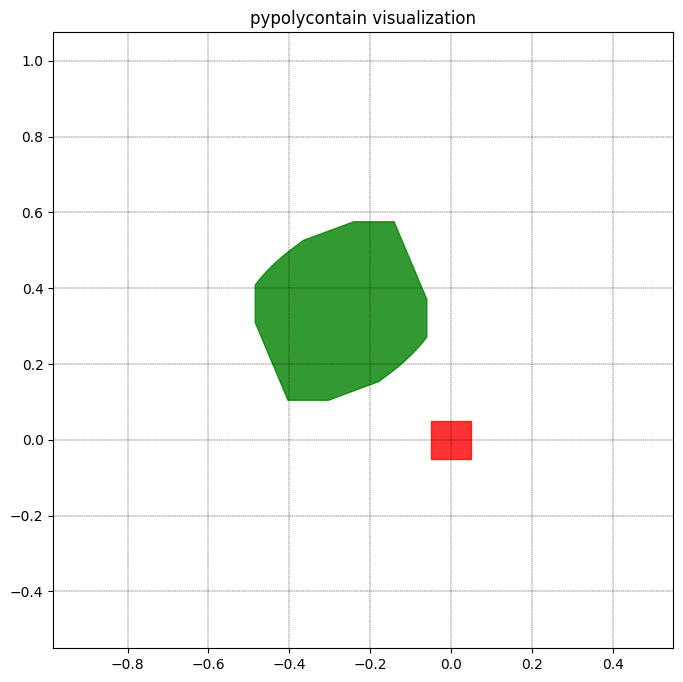

In [29]:
# visualization of Reachable set (projected to xy-plane)
fig, ax = plt.subplots()
# 2D zonotope
R2d = pp.zonotope(x=R.x[0:2],G=R.G[0:2,:])
try:
    pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :], color='red'), pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
    # pp.visualize([pp.zonotope(x=X0.x[0:2], G=X0.G[0:2, :], color='red')], fig=fig, ax=ax)
except:
    pass
plt.show()

In [30]:
# Linearization Error bounds as zonotope
Rw = pp.zonotope(x=np.zeros(3), G=np.diag(linearization_error))

Here, we will also visualize some of the sampled trajectories. Why is the reachable set much larger than the actual sampled final states? In case you want to find out, sample some trajectories where you just take the extreme values of $\mathbf{u}$ over the entire trajectory and visualize them!

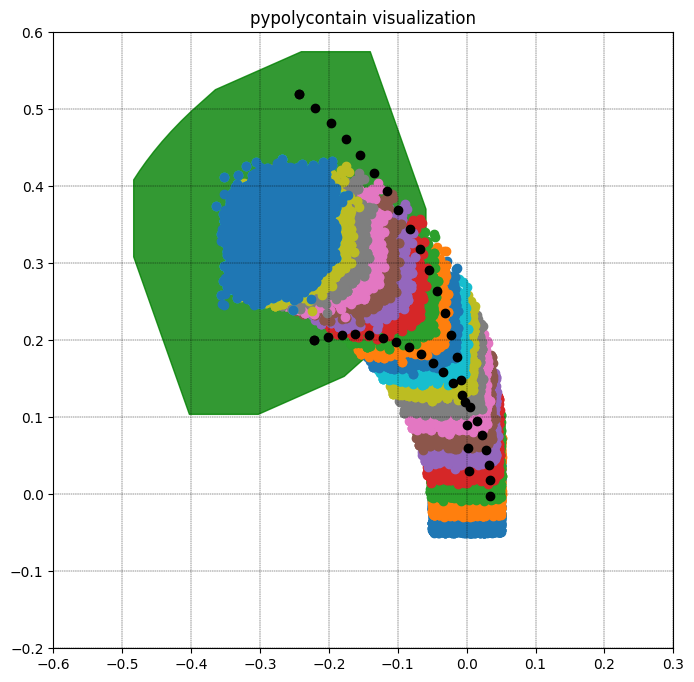

In [31]:
fig, ax = plt.subplots()
try:
    pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax)
except:
    pass

idx = np.random.randint(n_samples, size=10000)


# Optional: sample corner case scenarios and visualize them

for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
for i in range(0, N_s):
    plt.scatter(state_extreme_1[:, 0, i], state_extreme_1[:, 1, i], color = 'k')
    plt.scatter(state_extreme_2[:, 0, i], state_extreme_2[:, 1, i], color = 'k')
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
plt.scatter(state_extreme_1[:, 0, -1], state_extreme_1[:, 1, -1], color= 'k')
plt.scatter(state_extreme_2[:, 0, -1], state_extreme_2[:, 1, -1], color = 'k')

ax.set_xlim([-0.6, 0.3])
ax.set_ylim([-0.2, 0.6])
plt.show()

Now, the goal is to find a control policy $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0$ s.t. the reachable set is shrunk to the linearization error meaning that $\mathcal{R}_u$ cancels out $\mathcal{R}_x$, i.e. $\mathbf{A} - \mathbf{BK} = \mathbf{0}$. Note, that this is a mapping from the initial state to a sequence of control inputs, thus $\mathbf{K} \in \mathbb{R}^{n_x \times n_u (N_s - 1)}$. However, this problem cannot be uniquely solved since the $\mathbf{B}$ matrix is not invertible. One approach to solve for a feedback matrix is to use the pseudoinverse $\mathbf{K} = \mathbf{B}^\dagger \mathbf{A}$ which, however, does not ensure that our inputs $\mathbf{u}_{0:(N_s-1)} = -\mathbf{K} \mathbf{x}_0 \in U$ are inside the feasible control set. An alternative is to formulate this as an optimization problem in which we would like to minimize the control effort (magnitude of $\mathbf{K}$) subject to reachable set cancellation and input constraints:

$$
\begin{aligned}
	\min_{K = [K_{ij}]} \quad &[K_{11}, K_{12}, \dots, K_{nm}]^T Q [K_{11}, K_{12}, \dots, K_{nm}]\\
	\textrm{s.t.  } \quad  &A - BK= 0\\
  \quad &-Kv \in U, \forall v \in \mathrm{vertices}(X0)
    \end{aligned}.
$$
Due to linearity, it is sufficient to enforce input constraints at the vertices of the initial state set!

In the last tutorial, we have used pythons `CVXOPT` library to efficiently solve a quadratic program for control synthesis. Since the optimization problem is also a QP, we can make use of the same library. Have a look at $\href{https://cvxopt.org/examples/tutorial/qp.html}{this} $ example on formulating a QP in cvxopt.

Explaining np.kron usage for Ax=B in qp: 

<img src="Images/Tut2/kron.jpeg" alt="Drawing" style="width: 500px;"/>


In [32]:
# print(B.shape)
# print(A.shape)

Kx = nx
Ky =  (nu * (N_s-1))

vertices_XO = pp.zonotope_to_V(X0)
G_ineq = []
h_constraint = np.array([[0.35, 1], [-0.2, -0.5]])
h_constraint= np.tile(h_constraint, nu * (N_s - 1))
vert = vertices_XO[0]
vert_array = np.array(vert)
vert_array = np.tile(vert_array, (2,1))

vert_array[1, :] = -vert_array[1, :]
# print(vert_array)

vertices_XO = pp.zonotope_to_V(X0)
# print(vertices_XO)
ver_count = len(pp.zonotope_to_V(X0))
G_ineq = np.zeros((2*ver_count, nx))
# print(G_ineq.shape)
h_constraint = np.array([[0.35, 1], [-0.2, -0.5]])
h_constraint= np.tile(h_constraint, (ver_count, N_s - 1)) 
# print(h_constraint.shape)


In [33]:
# Some imports for the QP formulation
from cvxopt import matrix, solvers
# set up QP
# number of decision variables
Kx = nx
Ky =  (nu * (N_s-1))

# Given that the QP equation is defined as 1/2 x^TPx + q^Tx where Q = 0.5P, q = p = 0
# Add tc = "d" to avoid the d type error
# K_opt is a vector of size (114 x1), Q = (114 x 114)
Q = 2 * matrix(np.eye(Kx*Ky, Kx*Ky), tc = 'd')
p = matrix(np.zeros((Kx*Ky, 1))) 

# Equality constraints, A_eq x = b_eq || B K_op = A so A_eq = B, b_eq = A
A_eq = matrix(np.kron(B, np.eye(Nx)))
A_row, A_col = A.shape
b_eq = matrix(np.reshape(A, (A_row*A_col, 1)))

vertices_XO = pp.zonotope_to_V(X0)
ver_count = len(pp.zonotope_to_V(X0))

# For h_ineq use the constraints given by the zonotope U, so the feasible input set is bounded by 0.05 in u1 and 0.25 in u2
h_ineq = np.array([[0.05, 0.05, 0.25, 0.25]]).T #  -(lowu1, lowu2), where lowu1 = -0.05 -->hence plus 
h_ineq = np.tile(h_ineq, ((N_s-1)*ver_count,1))

# Initialize G_ineq matrix
G_ineq = np.empty((0, Ky*Kx))

for ver_ex in vertices_XO:
    G = np.kron(np.eye(Ky), ver_ex)
    G= np.repeat(G, 2, axis= 0)
    G_ineq = np.vstack((G_ineq, G))

G_ineq[1::2, :] *= -1 # negate every second row for lower boundary 
solvers.options['show_progress'] = True
sol = solvers.qp(Q, p, matrix(G_ineq), matrix(h_ineq), A_eq, b_eq)
K = np.array(sol['x']).reshape(Ky, Kx)

print("Test: A-BK = " + str(A - B @ K))


     pcost       dcost       gap    pres   dres
 0:  4.4267e+01 -5.5452e+01  9e+02  6e+00  2e-15
 1:  4.4268e+01 -2.7745e+01  1e+02  7e-01  2e-15
 2:  4.6170e+01 -1.1261e+01  1e+02  5e-01  4e-15
 3:  5.2031e+01  1.9634e+01  1e+02  4e-01  1e-14
 4:  7.4570e+01  6.4087e+01  9e+01  2e-01  3e-14
 5:  9.4020e+01  8.8719e+01  6e+01  1e-01  2e-14
 6:  1.0809e+02  1.0113e+02  5e+01  7e-02  2e-14
 7:  1.1993e+02  1.1317e+02  3e+01  4e-02  2e-14
 8:  1.2856e+02  1.2144e+02  2e+01  1e-02  2e-14
 9:  1.3438e+02  1.2880e+02  7e+00  2e-03  4e-14
10:  1.3461e+02  1.3409e+02  7e-01  2e-04  1e-13
11:  1.3460e+02  1.3454e+02  7e-02  1e-05  4e-13
12:  1.3459e+02  1.3459e+02  3e-03  5e-07  2e-12
13:  1.3459e+02  1.3459e+02  3e-05  5e-09  3e-12
Optimal solution found.
Test: A-BK = [[-2.22044605e-16  6.65564609e-17  1.11022302e-16]
 [ 3.07642366e-17 -1.11022302e-16  0.00000000e+00]
 [-2.20807293e-16 -1.01368370e-16 -2.22044605e-16]]


In [34]:
print("A", A.shape)
print("B", B.shape)
print("K", K.shape)
print((A-B@K).shape)

A (3, 3)
B (3, 38)
K (38, 3)
(3, 3)


Let's see if it worked! Use the initial state set X0 and forward propagate the closed loop dynamics!

In [35]:
# state trajectories for controlled system --> feedback motion primitives 
feedback_state_traces = np.zeros((n_samples, nx, N_s))
# feedback_state_traces[:, :, 0] = ((state_traces[:, :, 0]).T).T
for i in range(n_samples):
    feedback_state_traces[i,:,0] = sample_zonotope(X0)
u_center = (np.array([U.x])).T
u_ff = np.tile(u_center, (N_s-1, n_samples))
K_x0 = - (K @ (feedback_state_traces[:, :, 0]).T) # 38x 10k, constant
u_feedback = u_ff + K_x0 # 38x10k
u_feedback_dynamics = u_feedback.T # 10k x 38

# u = uff - Kx  for all possible x where uff = 38 x1 and 38x3 3x10k -> 38 x 10k  || xk+1 = Axk + B(uff - Kx0) --> 
for i in range(1, N_s):
    # Use discrete dynamics model
    feedback_state_traces[:, :, i] = discrete_dynamics(feedback_state_traces[:, :, i-1], u_feedback_dynamics[:, 2*(i-1):2*i])
print(feedback_state_traces[9999, :, -1], "\n")


[-0.27174739  0.34064025  1.425     ] 



(-0.1, 1.0)

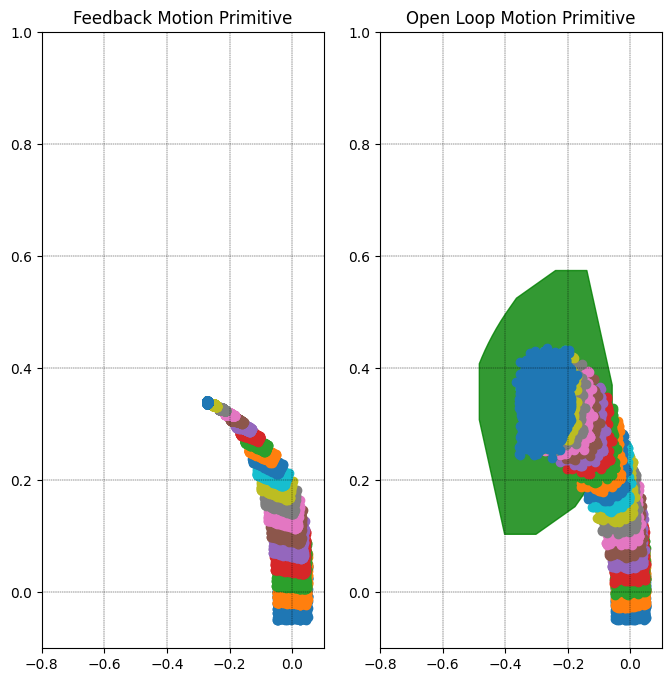

In [36]:
# visualizations of feedback motion primitives
fig = plt.figure()
ax = fig.add_subplot(121)

# Visualize feedback samples
idx = np.random.randint(n_samples, size=1000)
try:
    pp.visualize([pp.zonotope(x=Rw.x[0:2] + R.x[0:2], G=Rw.G[0:2, :])], fig=fig, ax=ax, title="Feedback Motion Primitive")
except:
    pass
for i in range(0, N_s):
    plt.scatter(feedback_state_traces[idx, 0, i], feedback_state_traces[idx, 1, i])
plt.scatter(feedback_state_traces[:, 0, -1], feedback_state_traces[:, 1, -1])
ax.set_xlim([-0.8, 0.1])
ax.set_ylim([-0.1, 1.])

ax1 = fig.add_subplot(122)

# visualize open loop samples
idx = np.random.randint(n_samples, size=1000)
try:
    pp.visualize([pp.operations.pca_order_reduction(R2d, 6)], fig=fig, ax=ax1, title="Open Loop Motion Primitive")
except:
    pass
for i in range(0, N_s):
    plt.scatter(state_traces[idx, 0, i], state_traces[idx, 1, i])
plt.scatter(state_traces[:, 0, -1], state_traces[:, 1, -1])
ax1.set_xlim([-0.8, 0.1])
ax1.set_ylim([-0.1, 1.])

**We are almost there!** We now have a single feedback motion primitive and we have canceled out the two reachable sets $\mathcal{R}_x$ and $\mathcal{R}_u$ and are only left with the linearization error. For our future analysis we are not only interested in where the robot will end up but also in all possible positions that the robot might reach when using the obtained controller. Thus, we are interested in the reachable tube of the feedback motion primitive! Since we've done a discrete analysis, we have to be careful as we are not entirely sure what happens in between discrete time steps... Next, use the samples from the closed loop system to obtain polygons that contain all the samples at each discrete time step $t_i$. Then, use some method to account for the continuous-time evolution in between time steps.

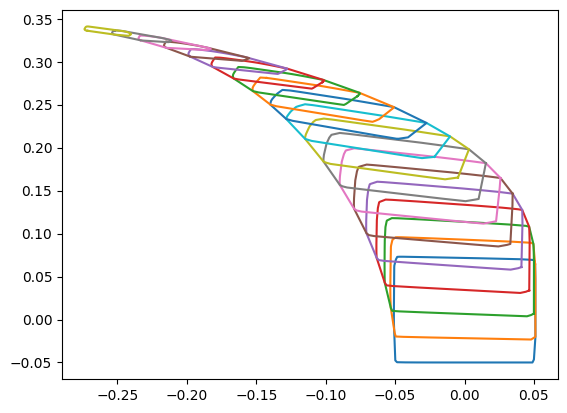

In [33]:
from scipy.spatial import ConvexHull
reachable_tube = []
for i in range(N_s-1):
    vertices_feedback = np.vstack((feedback_state_traces[:, 0:2, i], feedback_state_traces[:, 0:2, i+1]))
    hull= ConvexHull(vertices_feedback)
    hull_vertices = vertices_feedback[hull.vertices]
    poly_feedback = Poly([tuple(point) for point in hull_vertices])
    reachable_tube.append(poly_feedback)

fig = plt.figure()
ax = fig.add_subplot(111)
for rt in reachable_tube:
  x, y = rt.exterior.coords.xy
  plt.plot(x, y)

Amazing! Recap what we've just obtained: We have 

1.   a contracting motion primitive (Final set is smaller than initial set)
2.   a controller $\mathbf{u}_{0:(N_s - 1)} = - \mathbf{K} \mathbf{x}_0$ that maps the initial state to a sequence of control inputs
3. a reachable tube that can be used for collision checking



# Long horizon planning using Feedback Motion Primitives!

Now you know how to generate a single feedback motion primitive given an initial state set $X0$ as well as an input set $U$. The cool thing about feedback motion primitives is that they are a contraction on the state set meaning that they always "shrink" the initial state set. Thus, if we have multiple feedback motion primitives, we can concatenate them since the initial set of a motion primitive is always larger than the end of a motion. This concept is illustrated in the following figure.

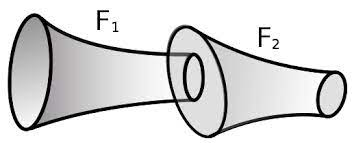

The goal of this section is to come up with an algorithm that connects multiple feedback motion primitives such that we can reach a goal while avoiding collisions with obstacles. We will consider the same static environment as in the first section.

Implement a function that returns N feedback motion primitives starting at the initial set $X0$ with different input sets $U_1, \dots, U_N$ where each input set is defined as $U_i = \left\{[u_1, u_2]^T \in \mathbb{R}^2 \mid 0.2 \leq u_1 \leq 0.3, u_{i, min} \leq u_2 \leq u_{i, max}\right\}$. The input sets should be distributed equidistantly, e.g. $u_{1, min} = u_{min}, u_{N, max} = u_{max}$ and $u_{i, max} = u_{i+1, min}$. Also, represent each feedback motion primitive as a class object of type FBMotion. We later want to use these primitives for collision checking, so it will be useful to also include attributes such as reachable_tube.

In [34]:
import trimesh as tm
from mpl_toolkits.mplot3d import Axes3D
from grahamscan import *
class FBMotion:
  def __init__(self, X0_set, U_set):
    self.Verbose = True
    self.reachable_tube = []
    self.n_samples = 10000
    self.nx = 3
    self.nu = 2
    self.N_s = 20
    self.feedback_state_traces = np.zeros((self.n_samples, self.nx, self.N_s))
    self.A = np.zeros((self.nx, self.nx))
    self.B = np.zeros((self.nx, self.nu * (self.N_s -1)))
    self.K = np.zeros((self.nu * (self.N_s -1), self.nx))
    self.state_traces = np.zeros((self.n_samples, self.nx, self.N_s)) # 10000, 3, 20
    self.input_traces = np.zeros((self.n_samples, self.nu, self.N_s - 1)) # 10000, 2, 19

    self.X0 = X0_set
    self.U = U_set
    self.reachable_tube = []
    self.dimension = None
    self.subdivisions = 3
    self.planar = None

  
  def dynamics(self, x, u):
      """
      Inputs: current state of the system x, control input u
      Output: derivative of the state vector
      """
      dx = np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T
      return dx


  def discrete_dynamics(self, x, u):
      """
      Inputs: current state of the system x, control input u
      Output: next state vector
      """
      dt = 0.1
      x_next = x + dt * self.dynamics(x, u)
      # dx = (np.array([- u[:, 0] * np.sin(x[:, 2]), u[:, 0] * np.cos(x[:, 2]), u[:, 1]]).T)
      # x_next = x + dt*dx
      return x_next

  def sample_zonotope(self, zt):
    """
    Input: pp zonotope
    Output: uniformly sampled point inside zonotope
    """
    z_center = zt.x
    x = [center -zt.G[ind][ind] + random.random() * 2* zt.G[ind][ind] for ind, center in enumerate(z_center)]

    return x
  
  def sample_initial_states(self):
    if self.Verbose:
      print("\n Initial state sampling started ...")
    # Define first column of state_traces, needed in order to compute the future time values
    for n in range(self.N_s-1):
        for j in range(self.n_samples):
            self.input_traces[j, :, n] = self.sample_zonotope(self.U)
            
    for j in range(self.n_samples):
        self.state_traces[j, :, 0] = self.sample_zonotope(self.X0)

    # Fill in rest of the columns using discrete_dynamics
    for i in range(self.N_s-1):
        x_next = self.discrete_dynamics(self.state_traces[:, :, i], self.input_traces[:, :, i])
        self.state_traces[:, :, i+1] = x_next

    return 
  
  def model_regression(self):
    if self.Verbose:
      print("\n Model regression started ...")
    # Seperate data into training and test set: 2/3 training 1/3 test
    ind = int(np.floor((2/3) * self.n_samples))

    # training set
    initial_states_train = self.state_traces[:ind, :, 0] # the way its defined here : samples, state, time --> structure above accordingly
    inputs_train = np.moveaxis(self.input_traces[:ind, :, :], 1, -1).reshape((ind, -1))
    training_input = np.concatenate((initial_states_train, inputs_train), axis=1)
    training_output = self.state_traces[:ind, :, -1]
    model = LinearRegression().fit(training_input, training_output)

    # obtain model
    A = model.coef_[:, :self.nx]
    B = model.coef_[:, self.nx:]
    c = model.intercept_

    self.A = A
    self.B = B


    # test set
    initial_states_test = self.state_traces[ind:, :, 0] 
    inputs_test = np.moveaxis(self.input_traces[ind:, :, :], 1, -1).reshape((self.n_samples - ind, -1))
    test_input = np.concatenate((initial_states_test, inputs_test), axis=1)
    test_output = self.state_traces[ind:, :, -1]

    # Error on training set
    prediction = model.predict(training_input)
    err_training = abs(prediction - training_output)
    max_error_training = np.max(err_training, axis=0)
    # print("Max error on training data: " + str(max_error_training))

    # Error on test set
    prediction = model.predict(test_input)
    err_test = abs(prediction - test_output)
    max_error_test = np.max(err_test, axis=0)
    # print("Max error on test data: " + str(max_error_test))

    # overapproximate linearization error
    linearization_error = max_error_test * 1.5

    return 
  
  def K_solver(self):
    if self.Verbose:
       print("\n K solver started ...")

    Kx = self.nx
    Ky =  (self.nu * (self.N_s-1))

    # Given that the QP equation is defined as 1/2 x^TPx + q^Tx where Q = 0.5P, q = p = 0
    # Add tc = "d" to avoid the d type error
    # K_opt is a vector of size (114 x1), Q = (114 x 114)
    Q = 2 * matrix(np.eye(Kx*Ky, Kx*Ky), tc = 'd')
    p = matrix(np.zeros((Kx*Ky, 1))) 


    # Equality constraints, A_eq x = b_eq || B K_op = A so A_eq = B, b_eq = A
    A_eq = matrix(np.kron(self.B, np.eye(self.nx)))
    A_row, A_col = self.A.shape
    b_eq = matrix(np.reshape(self.A, (A_row*A_col, 1)))

    vertices_XO = pp.zonotope_to_V(self.X0)
    ver_count = len(pp.zonotope_to_V(self.X0))

    # For h_ineq use the constraints given by the zonotope U, so the feasible input set is bounded by 0.05 in u1 and 0.25 in u2
    u1_min = - self.U.G[0][0]
    u1_max = self.U.G[0][0]
    u2_min = - self.U.G[1][1]
    u2_max = self.U.G[1][1]
    h_ineq = np.array([[u1_max, -u1_min, u2_max, -u2_min]]).T #  -(lowu1, lowu2), where lowu1 = -0.05 -->hence plus
    h_ineq = np.tile(h_ineq, ((self.N_s-1)*ver_count,1))

    # Initialize G_ineq matrix
    G_ineq = np.empty((0, Ky*Kx))

    for ver_ex in vertices_XO:
        G = np.kron(np.eye(Ky), ver_ex)
        G= np.repeat(G, 2, axis= 0)
        G_ineq = np.vstack((G_ineq, G))

    G_ineq[1::2, :] *= -1 # negate every second row for lower boundary 
    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, matrix(G_ineq), matrix(h_ineq), A_eq, b_eq)
    K = np.array(sol['x']).reshape(Ky, Kx)
    self.K = K

    return 

  def feedback_st(self):
    if self.Verbose:
      print("\n Feedback state traces started ...")
    # compute feedback state traces
    for i in range(self.n_samples):
      self.feedback_state_traces[i,:,0] = self.sample_zonotope(self.X0)

    u_center = (np.array([self.U.x])).T
    u_ff = np.tile(u_center, (self.N_s-1, self.n_samples))
    K_x0 = - (self.K @ (self.feedback_state_traces[:, :, 0]).T) # 38x 10k, constant
    u_feedback = u_ff + K_x0 # 38x10k
    u_feedback_dynamics = u_feedback.T # 10k x 38

    # u = uff - Kx  for all possible x where uff = 38 x1 and 38x3 3x10k -> 38 x 10k  || xk+1 = Axk + B(uff - Kx0) --> 
    for i in range(1, self.N_s):
        # Use discrete dynamics model
        self.feedback_state_traces[:, :, i] = self.discrete_dynamics(self.feedback_state_traces[:, :, i-1], u_feedback_dynamics[:, 2*(i-1):2*i])

  def reach_tube(self):
    if self.Verbose:
      print("\n Reachable tube started ...")
    # compute reachable tube
    
    for i in range(self.N_s-1):
      vertices_feedback = np.vstack((self.feedback_state_traces[:, 0:2, i], self.feedback_state_traces[:, 0:2, i+1]))
      poly_feedback, pts_sorted_feedback = graham_scan(vertices_feedback)
      self.reachable_tube.append(poly_feedback)
    return 
  
  def reach_tube_polygon(self):
    if self.Verbose:
      print("\n 2D: Reachable tube polygon started ...")
    # compute reachable tube
    for i in range(self.N_s-1):
      vertices_feedback = np.vstack((self.feedback_state_traces[:, 0:2, i], self.feedback_state_traces[:, 0:2, i+1]))
      hull= ConvexHull(vertices_feedback)
      hull_vertices = vertices_feedback[hull.vertices]
      poly_feedback = Poly([tuple(point) for point in hull_vertices])
      self.reachable_tube.append(poly_feedback)
    return
  
  def reach_tube_planars(self):
    if self.Verbose:
      print("\n 2D: List of reachble tubes for xy, yz, xz planes started ...")
    # compute reachable tube
    planar_tubes = []
    for k in [[0,1], [1,2], [0,2]]:
      oneplanar_tube = []
      for i in range(self.N_s-1):
        vertices_feedback = np.vstack((self.feedback_state_traces[:, k, i], self.feedback_state_traces[:, 0:2, i+1]))
        hull= ConvexHull(vertices_feedback)
        hull_vertices = vertices_feedback[hull.vertices]
        poly_feedback = Poly([tuple(point) for point in hull_vertices])
        oneplanar_tube.append(poly_feedback)
      planar_tubes.append(oneplanar_tube)
    self.reachable_tube.append(planar_tubes)
    return
  

  def reach_tube_polyhedron(self):
    if self.Verbose:
      print("\n 3D: Reachable tube polyhedrons started ...")
    for i in range(self.N_s -1):
      vertices_feedback = np.vstack((self.feedback_state_traces[:, :, i], self.feedback_state_traces[:, :, i+1]))
      hull = ConvexHull(vertices_feedback)
      poly_feedback = tm.Trimesh(vertices = hull.points, faces = hull.simplices)
      for _ in range(self.subdivisions):
        poly_feedback = poly_feedback.subdivide()
      self.reachable_tube.append(poly_feedback)
    return 
  
  def reach_tube_polyhedron_2(self):
    if self.Verbose:
      print("\n 3D: Reachable tube polyhedrons started ...")
    for i in range(self.N_s -1):
      vertices_feedback = np.vstack((self.feedback_state_traces[:, :, i], self.feedback_state_traces[:, :, i+1]))
      poly_feedback = tm.convex.convex_hull(vertices_feedback)
    self.reachable_tube.append(poly_feedback)

  def reach_tube_polyhedron_3(self):
    if self.Verbose:
      print("\n 3D: Reachable tube polyhedrons started ...")
    for i in range(self.N_s -1):
      vertices_feedback = np.vstack((self.feedback_state_traces[:, :, i], self.feedback_state_traces[:, :, i+1]))
      mesh = tm.Trimesh(vertices = vertices_feedback)
      hull_mesh = mesh.convex_hull
      poly_feedback = hull_mesh
    self.reachable_tube.append(poly_feedback)

  def plot_2D_planar(self, ax):
    for planar_tubes in self.reachable_tube:
      for one_planar_tubes in planar_tubes:
        for polygon in one_planar_tubes:
          x, y = polygon.exterior.coords.xy
          ax.plot(x, y)
          
  def plot_2D(self, ax):
    # plot reachable tube
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    for polygon in self.reachable_tube:
      x, y = polygon.exterior.coords.xy
      ax.plot(x, y)
      # plt.plot(x,y)

  def plot_3D(self, ax):
  # plot reachable tube
  # fig = plt.figure()
  # ax = fig.add_subplot(111)
    for polyhedron in self.reachable_tube:
      x = polyhedron.vertices[:, 0]
      y = polyhedron.vertices[:, 1]
      z = polyhedron.vertices[:, 2]
      ax.plot_trisurf(x, y, z)

  def plot_3D_2(self):
    tm.enable_notebook()
    scene = tm.Scene()
    for i, polyhedron in enumerate(self.reachable_tube):
      # point_cloud = tm.points.PointCloud(self.dataset_all[i])
      scene.add_geometry(polyhedron, geom_name = f'polyhedron_{i}')
      # scene.add_geometry(point_cloud, geon_name = f'point_cloud_{i}')
    scene.show()
    
  def run(self):
    self.sample_initial_states()
    self.model_regression()
    self.K_solver()
    self.feedback_st()
    if self.dimension == 2:
      if self.planar:
        self.reach_tube_planars()
      else:
        self.reach_tube_polygon()
      # self.plot_2D()
    elif self.dimension == 3:
      # self.reach_tube_polyhedron()
      self.reach_tube_polyhedron_3()
      # self.plot_3D()
    if self.Verbose:
      print("\n Feedback motion finished ...")
    return self.reachable_tube
  


 Initial state sampling started ...

 Model regression started ...

 K solver started ...

 Feedback state traces started ...

 3D: Reachable tube polyhedrons started ...

 Feedback motion finished ...


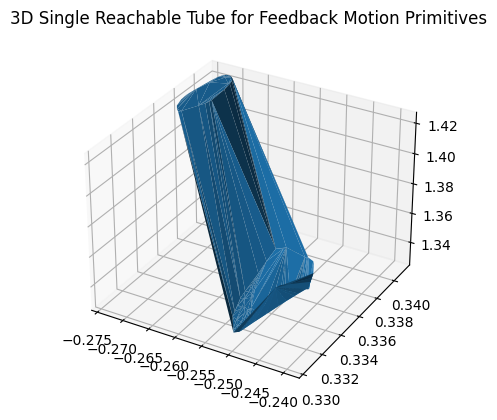

In [35]:
""" 
3D Single Reachable Tube for Feedback Motion Primitives Examples usign X0 and U
"""
X0 = pp.zonotope(x= np.array([0,0,0]), G = np.array([[0.05, 0, 0], [0, 0.05, 0], [0, 0, 0.05]]))
U = pp.zonotope(x = np.array([0.25, 0.75]), G= np.array([[0.05, 0], [0, 0.25]]))
feedbackmotion = FBMotion(X0, U)
feedbackmotion.Verbose = True
feedbackmotion.dimension = 3
feedbackmotion.run()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
feedbackmotion.plot_3D(ax)
plt.title("3D Single Reachable Tube for Feedback Motion Primitives")
plt.show()
# fig = plt.figure()
# feedbackmotion.plot_3D_2()


In [36]:
def generate_feedback_motion_primitives(X, u_min, u_max, N, dimension):
  """
  Input: Initial state set X as zonotope, u_min, u_max, number of motion primitives N, dimension of the convex hull (2 for polygon, 3 for polyhedron)
  Output: N equidistantly distributed (in input space of u2, keep u1 the same over all primitives) feedback motion primitives (list of FBMotion objects)
  """
  motion_primitives = []
  # PUT YOUR CODE HERE
  u_step = np.linspace(u_min, u_max, N+1)
  for i in range(N):
    u2_ncenter = (u_step[i] + u_step[i+1])/2
    u2_gen = u_step[i+1] - u2_ncenter
    U = pp.zonotope(x = np.array([0.25, u2_ncenter]), G= np.array([[0.05, 0], [0, u2_gen]]))
    feedback_motion = FBMotion(X, U)
    feedback_motion.Verbose = False
    feedback_motion.dimension = dimension
    motion_primitives.append(feedback_motion)

  return motion_primitives



Let's have a look at our motion primitives!

 Running primitive # 1/11
 Running primitive # 2/11
 Running primitive # 3/11
 Running primitive # 4/11
 Running primitive # 5/11
 Running primitive # 6/11
 Running primitive # 7/11
 Running primitive # 8/11
 Running primitive # 9/11
 Running primitive # 10/11
 Running primitive # 11/11


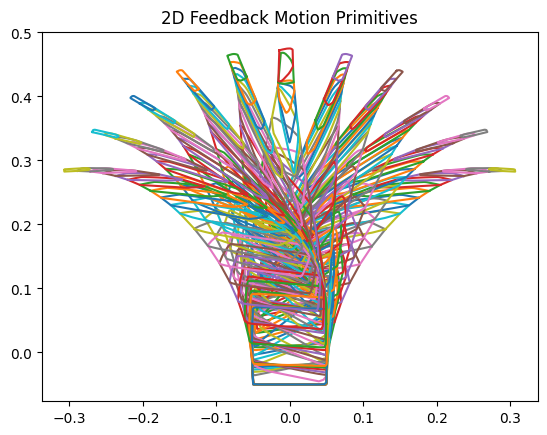

In [37]:
""" 
CALL 2D FEEDBACK MOTION PRIMITIVES & PLOT
"""
u_min = - 1
u_max = 1
primitives_2D = generate_feedback_motion_primitives(X0, u_min, u_max, 11, 2)

fig = plt.figure()
ax = fig.add_subplot(111)
for p in primitives_2D:
  print(f" Running primitive # {primitives_2D.index(p)+1}/{len(primitives_2D)}")
  p.run()
  p.plot_2D(ax)
plt.title("2D Feedback Motion Primitives")
plt.show()

In [38]:
from shapely import affinity
""" 
2D Motion Primitives : just the reachable tubes // 11 
"""
reach_primitives_2D = [] # poly type // end nodes of ever reachable tube for every motion primitive
for fbm_classes in primitives_2D:
    fbm_classes.dimensions = 2
    fbm_classes.run()
    center_of_rot = fbm_classes.reachable_tube[0].centroid # from the first polygon in the reachable tube list take centroid
    reach_primitives_2D.append(fbm_classes.reachable_tube) # append end poly for each motion primitive
print(len(reach_primitives_2D)) # Number of different end polygons 

11


In [40]:
from shapely import affinity
""" 
ROTATION OF REACHABLE TUBE POLYGONS IN 2 DIMENSIONAL SPACE
end_poly_list = list of end polygons for each motion primitive
"""
#TODO: CONSIDER THAT ACTUALLY WE ARE ONLY ALLOWED TO USE THE REACHABLE TUBES FOUND USING U [-1,1], so we have to rotate only based off of where our next point is chosen
rot_primitives_2D = [] # poly type // end nodes of ever reachable tube for every motion primitive
for fbm_classes in primitives_2D:
    fbm_classes.run()
    fbm_classes.dimensions = 2
    center_of_rot = fbm_classes.reachable_tube[0].centroid # from the first polygon in the reachable tube list take centroid
    rot_primitives_2D.append(fbm_classes.reachable_tube) # append end poly for each motion primitive
    for angle in [45, 90, 135, 180, 225, 270, 315]:
        rotated_poly_list = [affinity.rotate(reach_tube_poly, angle= angle, origin = center_of_rot, use_radians = False) for reach_tube_poly in fbm_classes.reachable_tube]
        rot_primitives_2D.append(rotated_poly_list)
print(len(rot_primitives_2D)) # Number of different end polygons 

88


In [41]:
center_of_rot = reach_primitives_2D[0][0].centroid # first poly of first reachable tube
center_of_trans = reach_primitives_2D[0][-1].centroid # last poly of any reachbale tube
heading_angle = (atan2(center_of_trans.y - center_of_rot.y, center_of_trans.x - center_of_rot.x))*180/pi -90 #subtract by 90 to get heading angle
print(heading_angle)
bearing = (heading_angle + 360) %360
print(bearing)
reach_tube_rot = []
for reach_tube in reach_primitives_2D:
    reach_tube_trans = []
    for polygon in reach_tube:
        poly_rotated = affinity.rotate(polygon, angle= heading_angle, origin= center_of_rot, use_radians = False)
        poly_translated = affinity.translate(poly_rotated, xoff=center_of_trans.x, yoff=center_of_trans.y)
        reach_tube_trans.append(poly_translated)
    reach_tube_rot.append(reach_tube_trans)

-46.433807190145004
313.566192809855


In [42]:
"""Fix ANGLES"""
from sklearn.decomposition import PCA
from shapely.geometry import Polygon
import numpy as np
import math

polygon1 = reach_primitives_2D[0][0] # first poly of first reachable tube
polygon2 = reach_primitives_2D[0][-1] # last poly of any reachbale tube

center_of_rot = polygon1.centroid # first poly of first reachable tube
center_of_trans = polygon2.centroid # last poly of any reachbale tube

coords1 = np.array(polygon1.exterior.coords)
coords2 = np.array(polygon2.exterior.coords)
# Perform PCA on the coordinates
pca = PCA(n_components=2)
pca.fit(coords1)
angle1 = np.arctan2(pca.components_[0, 1], pca.components_[0, 0])
pca.fit(coords2)
angle2 = np.arctan2(pca.components_[0, 1], pca.components_[0, 0]) 
heading_angle = math.degrees(angle2 - angle1) 

print(heading_angle)
reach_tube_rot = []
for reach_tube in reach_primitives_2D:
    reach_tube_trans = []
    for polygon in reach_tube:
        poly_rotated = affinity.rotate(polygon, angle= heading_angle, origin= center_of_rot, use_radians = False)
        poly_translated = affinity.translate(poly_rotated, xoff=center_of_trans.x, yoff=center_of_trans.y)
        reach_tube_trans.append(poly_translated)
    reach_tube_rot.append(reach_tube_trans)

285.0629321257315


In [43]:
from shapely.geometry import Polygon
import math

polygon1 = reach_primitives_2D[5][0] # first poly of first reachable tube
polygon2 = reach_primitives_2D[5][1] # last poly of any reachbale tube
polygon3 = reach_primitives_2D[5][-1] # first poly of first reachable tube
polygon4 = reach_primitives_2D[5][-3] # last poly of any reachbale tube

center_of_rot = polygon1.centroid # first poly of first reachable tube
center_of_trans = polygon3.centroid # last poly of any reachbale tube

centroid1 = polygon1.centroid
centroid2 = polygon2.centroid
centroid3 = polygon3.centroid
centroid4 = polygon4.centroid

angle1 = math.atan2(centroid2.y - centroid1.y, centroid2.x - centroid1.x) * 180 / pi 
angle2 = math.atan2(centroid3.y - centroid4.y, centroid3.x - centroid4.x) * 180 / pi
print("angle1", angle1)
print("angle2", angle2)
heading_angle = (angle2 - angle1)

print(heading_angle)
reach_tube_rot = []
for reach_tube in reach_primitives_2D:
    reach_tube_trans = []
    for polygon in reach_tube:
        poly_rotated = affinity.rotate(polygon, angle= heading_angle, origin= center_of_rot, use_radians = False)
        poly_translated = affinity.translate(poly_rotated, xoff=center_of_trans.x, yoff=center_of_trans.y)
        reach_tube_trans.append(poly_translated)
    reach_tube_rot.append(reach_tube_trans)


angle1 88.15834966574577
angle2 88.22858522200981
0.07023555626403777


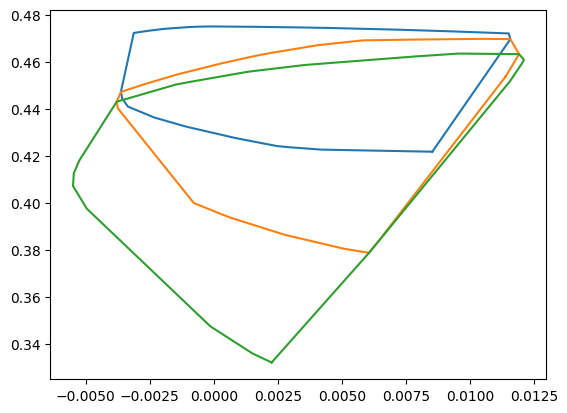

In [44]:
fig  = plt.figure()
x_tests, y_test = reach_primitives_2D[5][-1].exterior.coords.xy
x_tests_2, y_test_2 = reach_primitives_2D[5][-2].exterior.coords.xy
x_tests_3, y_test_3 = reach_primitives_2D[5][-3].exterior.coords.xy
plt.plot(x_tests, y_test)
plt.plot(x_tests_2, y_test_2)
plt.plot(x_tests_3, y_test_3)
plt.show()

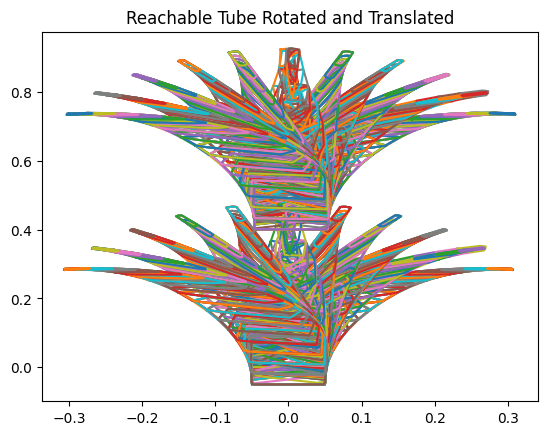

In [45]:
""" 
VISUAL OF ROTATED REACHABLE TUBE POLYGONS CENTROIDS
"""

fig = plt.figure()
ax = fig.add_subplot(111)
for id, reach_tube in enumerate(reach_tube_rot):
    reach_prim = reach_primitives_2D[id]
    for id, polygon in enumerate(reach_tube):
        x2, y2 = reach_prim[id].exterior.coords.xy
        x,y = polygon.exterior.coords.xy
        ax.plot(x,y)
        ax.plot(x2,y2)
    # reach_prim[-1].exterior.coords.xy
    ax.plot(center_of_rot.x, center_of_rot.y)

plt.title("Reachable Tube Rotated and Translated")
plt.show()


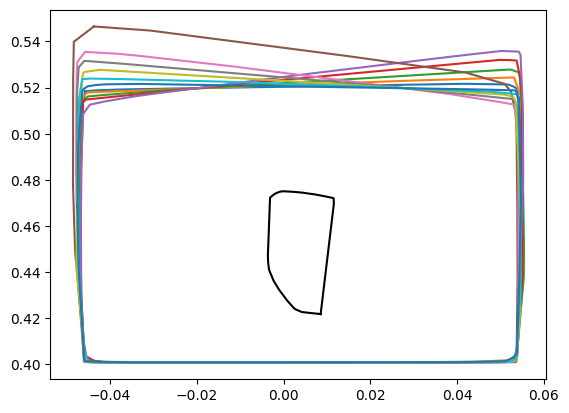

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
x_reach, y_reach = reach_primitives_2D[5][-1].exterior.coords.xy # last of first tube
ax.plot(x_reach, y_reach, 'k')
for rt_list in reach_tube_rot:
    x, y = rt_list[0].exterior.coords.xy
    ax.plot(x, y)
    

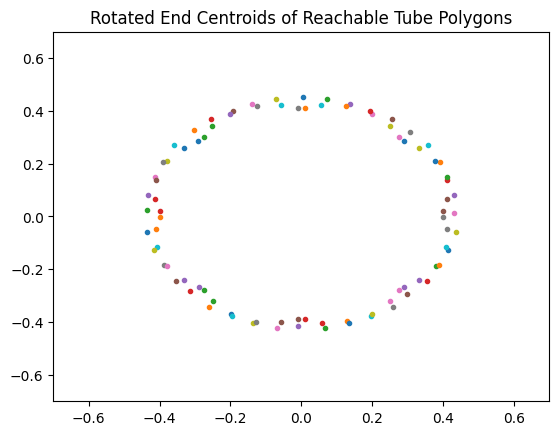

In [47]:
""" 
VISUAL OF ROTATED REACHABLE TUBE POLYGONS CENTROIDS
"""
fig = plt.figure()
for rp2D in rot_primitives_2D:
    end_poly = rp2D[-1]
    x = end_poly.centroid.x
    y = end_poly.centroid.y
    plt.plot(x,y, '.')
plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])
plt.title("Rotated End Centroids of Reachable Tube Polygons")
plt.show()


In [48]:
from shapely.geometry import Point
""" 
TRANSLATION OF END POLYGON LIST
"""
def translate_poly(rot_primitives_2D, pnext):
    """ 
    Take in end_list_poly and translate it to the next point chosen based off of heuristic
    Input: poly_list (list), current point (array), next point (array)
    Output: translated_poly_list (list)
    """
    x = pnext.x
    y = pnext.y

    trans_primitives_2D = []
    for reach_tube in rot_primitives_2D:
        reach_tube_trans = []
        for polygon in reach_tube:
            poly_translated = affinity.translate(polygon, xoff=x, yoff=y)
            reach_tube_trans.append(poly_translated)
        trans_primitives_2D.append(reach_tube_trans)

    return trans_primitives_2D

trans_primitives_2D = translate_poly(rot_primitives_2D, Point(np.array([0.5,0.5])))
print(len(trans_primitives_2D))
print(len(trans_primitives_2D[0]))



88
76


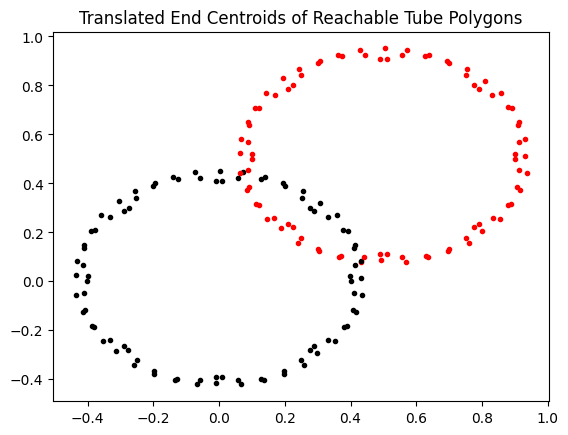

In [49]:
fig = plt.figure()
for i, reach_tube_trans in enumerate(trans_primitives_2D):
    end_tube = reach_tube_trans[-1]
    x = rot_primitives_2D[i][-1].centroid.x
    y = rot_primitives_2D[i][-1].centroid.y
    x_trans = end_tube.centroid.x
    y_trans = end_tube.centroid.y
    plt.plot(x,y, 'k.')
    plt.plot(x_trans,y_trans, 'r.')
plt.title("Translated End Centroids of Reachable Tube Polygons")
plt.show()

## A* path planning algorithm using motion primitives
In this last step, we will use the obtained N feedback motion primitives for a dynamically feasible A* search. In this section you are free in the way you implement the algorithm, e.g. how to choose costs and heuristics. The goal is to find a sequence of feedback motion primitives that bring the robot from its initial state $x_0$ to the goal state $x_G$ while always staying in the free space $\mathcal{X}\setminus \mathcal{X}_{obs}$.

Here are a couple of hints:


1.   Feedback motion primitives can be shifted and rotated in the configuration space. The final polygon of a motion primitive should always be entirely contained in the first polygon of the next motion primitive when concatenating them.
2.   It is fine if you find a solution that is "close" to the goal state. A solution is accepted if the center of the final polygon $c$ satisfies $\lVert \mathbf{c}_N - \mathbf{x}_G\rVert_2 \leq 0.2$.
3. You can use `shapely.affinity` for transformations and rotations of shapely polygons.
4. Optimality of the solution is not required.
5. The complexity of collision checking can be reduced by first using an overapproximation of the reachable tube. If that over approximation is collision free, you don't need to do complex collision checking.
6. A lot of implementations of the standart A* algorithm in python can be found online ;) 
7. A feasible solution could look something like this:

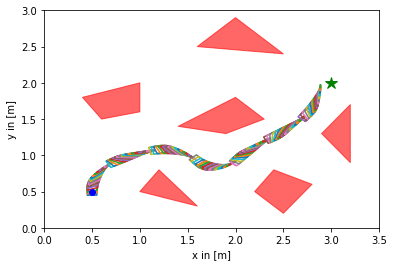



In [50]:
start_array = np.array([0.5,0.5,0])
goal_array = np.array([3,2,0])

In [51]:
from shapely import affinity

# feel free to use any other polygon representation
obstacles_shapely = [Polygon(o) for o in obstacles]

# robots initial state
x0 = np.array([0.5,0.5,0])
# goal state
xG = np.array([3., 2, 0])
# collision radius of robot
r = 0.2


In [52]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely import affinity
import numpy as np
from copy import deepcopy

import heapq

class PriorityQueue:
    ...
    def __init__(self):
        self.elements = []
        self.element_set = set()  # New set of elements

    def put(self, priority, item):
        heapq.heappush(self.elements, (priority, item))
        self.element_set.add(item)  # Add the item to the set

    def get(self):
        item = heapq.heappop(self.elements)[1]
        self.element_set.remove(item)  # Remove the item from the set
        return item

    def __contains__(self, item):
        return item in self.element_set  # Check the set instead of the list


class MotionPrimitive:
    """ 
    Defines cost & parent node of the motion primitive
    """
    def __init__(self, reachable_tube):
        self.reachable_tube = reachable_tube
        self.parent = None
        self.cost = 0

def polyhedron_centroid(polyhedron):
    """
    Calculate the centroid of a polyhedron
    Output: centroid (np.array)
    
    """
    centroid = polyhedron.centroid
    return centroid

def distance_heuristic(next,goal):
    """ 
    Calculate the heuristic cost from next to goal
    Input: next (Point()), goal (np.array)
    Output: heuristic cost (float)
    """
    # next and goal either Point() or centroid of Polygon
    
    distance = sqrt((next.x - goal.x)**2 + (next.y - goal.y)**2)
    return distance

def reach_goal_check(end_centroid_rt, goal):

    distance = distance_heuristic(end_centroid_rt, goal)
    if distance < 0.2:
        print("Goal reached!")
        return True
    else:
        return False
    

def translate_poly(rot_primitives_2D, pnext):
    """ 
    Take in end_list_poly and translate it to the next point chosen based off of heuristic
    Input: poly_list (list), current point (array), next point (array)
    Output: translated_poly_list (list)
    """
    #pnext either Point() or centroid of polygon
    x = pnext.x
    y = pnext.y

    trans_primitives_2D = []
    for reach_tube in rot_primitives_2D:
        reach_tube_trans = []
        for polygon in reach_tube:
            poly_translated = affinity.translate(polygon, xoff=x, yoff=y)
            reach_tube_trans.append(poly_translated)
        trans_primitives_2D.append(reach_tube_trans)

    return trans_primitives_2D

def collision_check(trans_primitives_2D, obstacles_shapely):
    collfree_primitives_2D = []
    for primitive in trans_primitives_2D:
        collision_detected = False
        for polygon in primitive:
            for obstacle in obstacles_shapely:
                if polygon.intersects(obstacle):
                    collision_detected = True
                    break
            if collision_detected:
                break
        if not collision_detected:
            collfree_primitives_2D.append(primitive)
    return collfree_primitives_2D

    
    
def subset_check(current_last_poly, rot_primitives_2D, current_end_centroid, obstacles_shapely):
    """ 
    Check if the last polyhedron in current is contained in final polyhedron of next
    If True then the entire reachable tube is feasible as neighbour

    Inputs:
    Current: list of polyhedrons (reachable tube) or the start array
    Current_last: last polyhedron in current reachable tube
    Rot_primitives_2D: list of all rotated motion primitives (reachable tubes)
    Current_end_centroid: centroid of the last polyhedron in current reachable tube

    Output: list of feasible motion primitives as MotionPrimitive class
    """
    #Translate the rot_primitives_2D to the origin of the current reachable tube
    ### TRANSLATE FIRST ###
    # copy_rot_primitives = deepcopy(rot_primitives_2D)
    trans_primitives_2D = translate_poly(rot_primitives_2D, current_end_centroid)

    ### CHECK IF LAST OF CURRENT IS CONTAINED INSIDE FIRST OF NEXT ###
    collfree_primitives_2D = collision_check(trans_primitives_2D, obstacles_shapely)
    feasible_MP = []
    print("Total collision free tubes:",len(collfree_primitives_2D))
    if len(collfree_primitives_2D) == 0:
        return feasible_MP
    for collfree_primitive in collfree_primitives_2D:
        next_first = collfree_primitive[0]
        if next_first.contains(current_last_poly):
            next_tube_class = MotionPrimitive(collfree_primitive)
            feasible_MP.append(next_tube_class)
    print("Feasible tubes",len(feasible_MP))
    return feasible_MP
    

def astar_2d(start_array, goal_array, rot_primitives_2D, obstacles_shapely):
    goal = Point(goal_array)
    start = Point(start_array)
    max_iterations = 10000
    iterations = 0
    open_set = PriorityQueue()
    start = MotionPrimitive(start) # start element a numpy array
    start.cost = 0
    open_set.put(0, start) # cost, np.array

    while len(open_set.element_set)>0 and iterations < max_iterations:
        # assign current to the item in the open_set that has minimum cost
        current_tube_class = open_set.get() # Motionprimitive class
        current_tube = current_tube_class.reachable_tube # current reachable tube (list of polyhedrons if not start)
        if np.all(current_tube == Point(start_array)):
            # if start array
            current_end_centroid = current_tube
            current_last_poly = current_tube
        else:
            # if polyhedron
            current_end_centroid =(current_tube[-1].centroid)
            current_last_poly = current_tube[-1]
        # check if current is  close enough to distance, if yes then terminate
        if reach_goal_check(current_end_centroid, goal):
            break
        # check for nearest neighbout of current in the open_set (subset & obstacle check)
        feasible_rot_primitives = subset_check(current_last_poly, rot_primitives_2D, current_end_centroid, obstacles_shapely)
        # for each feasible_rot_primitive assign cost and parent
        for next_primitive in feasible_rot_primitives:
            new_cost= current_tube_class.cost + next_primitive.cost
            if next_primitive not in open_set or new_cost < next_primitive.cost:
                next_primitive.cost = new_cost
                h_cost =  distance_heuristic(next_primitive.reachable_tube[-1].centroid, goal)
                priority = new_cost + distance_heuristic(next_primitive.reachable_tube[-1].centroid, goal)
                open_set.put(priority, next_primitive)
                next_primitive.parent = current_tube_class

        iterations += 1
        
    
    print("iterations", iterations)
    path = []
    while current_tube_class is not None:
        path.append(current_tube_class.reachable_tube)
        current_tube_class = current_tube_class.parent
        print(path)
    path.reverse()

    return path

In [53]:
obstacles_shapely= [Polygon(o) for o in obstacles]
elp_polys = []
for elp in enlarged_ellipses_patches:
    elp_polys.append(Poly(elp.get_verts()))

path = astar_2d(np.array([0,0]), np.array([3, 2]), rot_primitives_2D, elp_polys)

Total collision free tubes: 88
Feasible tubes 88
Total collision free tubes: 88
Feasible tubes 88
Total collision free tubes: 0
Total collision free tubes: 0
Total collision free tubes: 18
Feasible tubes 18
Total collision free tubes: 47
Feasible tubes 47
Total collision free tubes: 18
Feasible tubes 18
Total collision free tubes: 0
Total collision free tubes: 13
Feasible tubes 13
Total collision free tubes: 0
Total collision free tubes: 16
Feasible tubes 16
Total collision free tubes: 0
Total collision free tubes: 16
Feasible tubes 16
Total collision free tubes: 6
Feasible tubes 6
Total collision free tubes: 0
Total collision free tubes: 27
Feasible tubes 27
Goal reached!
iterations 16
[[<POLYGON ((2.669 1.822, 2.668 1.814, 2.668 1.783, 2.668 1.763, 2.668 1.74, 2...>, <POLYGON ((2.773 1.788, 2.772 1.833, 2.772 1.839, 2.771 1.844, 2.77 1.845, 2...>, <POLYGON ((2.78 1.806, 2.779 1.817, 2.777 1.855, 2.777 1.86, 2.775 1.864, 2....>, <POLYGON ((2.673 1.813, 2.674 1.791, 2.679 1.791, 2.682 

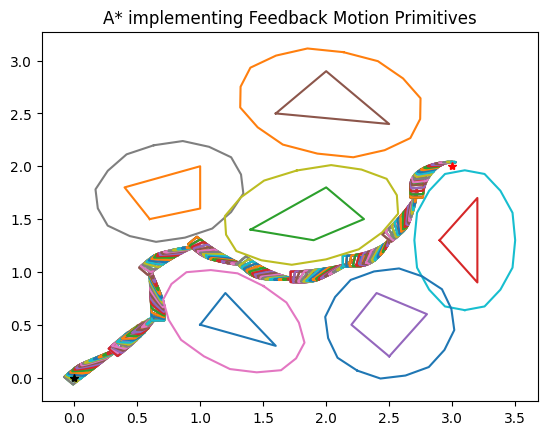

In [54]:
fig = plt.figure()
for tube in path[1:]:
    for poly in tube:
        x, y = poly.exterior.coords.xy
        plt.plot(x,y)

for obstacle in obstacles_shapely:
    x, y = obstacle.exterior.coords.xy
    plt.plot(x,y)

for obstacle in elp_polys:
    x, y = obstacle.exterior.coords.xy
    plt.plot(x,y)
plt.plot(0,0, 'k*')
plt.plot(3,2, 'r*')
plt.title("A* implementing Feedback Motion Primitives")
plt.show()